## Imports

In [187]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import rebound as rb
import celmech as cm
from celmech.miscellaneous import frequency_modified_fourier_transform as fmft
from itertools import product, combinations_with_replacement

try:
	plt.style.use('/Users/dtamayo/.matplotlib/paper.mplstyle')
except:
	pass

## Load asteroid data and create simulation

In [ ]:
# Read the table with the defined column specifications
df = pd.read_fwf('/Users/mac/MPCORB.DAT', colspecs=[[0,7], [8,14], [15,19], [20,25], [26,35], [36,46], [47, 57], [58,68], [69,81], [82, 91], [92, 103]])
df = df[df['Epoch'] == 'K239D'] # take only ones at common epoch--almost all of them

df.infer_objects()
for c in ['a', 'e', 'Incl.', 'Node', 'Peri.', 'M']:
	df[c] = pd.to_numeric(df[c])

df.head()

In [170]:
labels = pd.read_fwf('/Users/mac/proper_catalog24.dat', colspecs=[[0,10], [10,18], [19,28], [29,37], [38, 46], [47,55], [56,66], [67,78], [79,85], [86, 89], [90, 97]], header=None, index_col=False, names=['propa', 'da', 'prope', 'de', 'propsini', 'dsini', 'g', 's', 'H', 'NumOpps', "Des'n"])
labels.head()

,propa,da,prope,de,propsini,dsini,g,s,H,NumOpps,Des'n
0,2.767028,2.300000e-05,0.115193,0.00016,0.167560,0.000013,54.253800,-59.249995,3.34,123,00001
1,2.771276,1.200000e-04,0.280234,0.00034,0.546016,0.000045,-1.372312,-46.451120,4.12,121,00002
2,2.669376,7.500000e-06,0.233600,0.00001,0.229144,0.000003,43.858531,-61.476025,5.17,114,00003
3,2.361512,5.900000e-08,0.099452,0.00014,0.111023,0.000180,36.882605,-39.610314,3.22,110,00004
4,2.577657,2.900000e-05,0.171249,0.01200,0.076113,0.001400,52.506470,-51.132322,7.00,87,00005


In [171]:
merged_df = pd.merge(df, labels, on="Des'n", how="inner")
merged_df.shape, labels.shape

((1249051, 21), (1249051, 11))

In [ ]:
sim = rb.Simulation('/Users/mac/Downloads/planets.bin')
sim.add("Sun", date=date)
sim.add("Jupiter", date=date)
sim.add("Saturn", date=date)
sim.add("Uranus", date=date)
sim.add("Neptune", date=date)

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Uranus'... 
Found: Uranus Barycenter (7) (chosen from query 'Uranus')
Searching NASA Horizons for 'Neptune'... 
Found: Neptune Barycenter (8) (chosen from query 'Neptune')


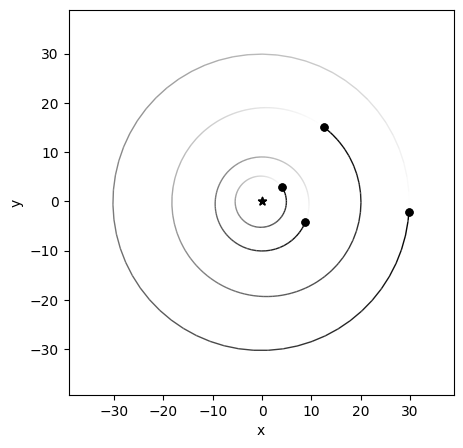

In [173]:
rb.OrbitPlot(sim)

In [174]:
row = merged_df.iloc[0]
row

Des'n           00001
H_x              3.34
G                0.15
Epoch           K239D
M            60.07879
Peri.        73.42179
Node         80.25496
Incl.        10.58688
e            0.078913
n           .21410680
a            2.767254
propa        2.767028
da           0.000023
prope        0.115193
de            0.00016
propsini      0.16756
dsini        0.000013
g             54.2538
s          -59.249995
H_y              3.34
NumOpps           123
Name: 0, dtype: object

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Uranus'... 
Found: Uranus Barycenter (7) (chosen from query 'Uranus')
Searching NASA Horizons for 'Neptune'... 
Found: Neptune Barycenter (8) (chosen from query 'Neptune')


2.7465720039477235

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


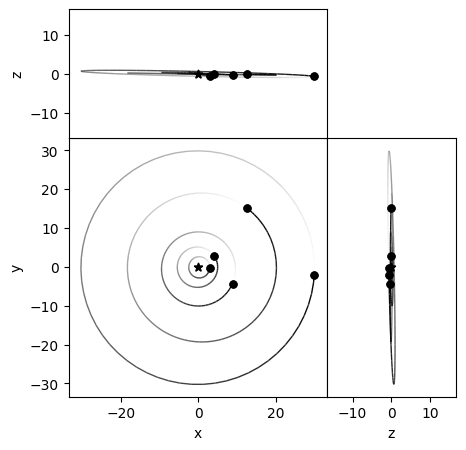

In [175]:
# sim = rb.Simulation('planets.bin')
# sim.add(a=row['a'], e=row['e'], inc=row['Incl.'], Omega=row['Node'], omega=row['Peri.'], M=row['M'], primary=sim.particles[0])

sim = rb.Simulation()
sim.add("Sun", date=date)
sim.add("Jupiter", date=date)
sim.add("Saturn", date=date)
sim.add("Uranus", date=date)
sim.add("Neptune", date=date)

sim.add(a=row['a'], e=row['e'], inc=row['Incl.']*np.pi/180, Omega=row['Node']*np.pi/180, omega=row['Peri.']*np.pi/180, M=row['M'], primary=sim.particles[0])
sim.move_to_com()

rb.OrbitPlotSet(sim)

ps = sim.particles
ps[-1].a

/Users/mac/planetary_lab/action-angle-discovery/.venv/lib/python3.10/site-packages/rebound/simulationarchive.py:152: RuntimeWarning: The simulation might not be synchronized. You can manually synchronize it by calling sim.synchronize().
  warnings.warn("The simulation might not be synchronized. You can manually synchronize it by calling sim.synchronize().", RuntimeWarning)


CPU times: user 51.3 s, sys: 29 s, total: 1min 20s
Wall time: 1min 21s


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


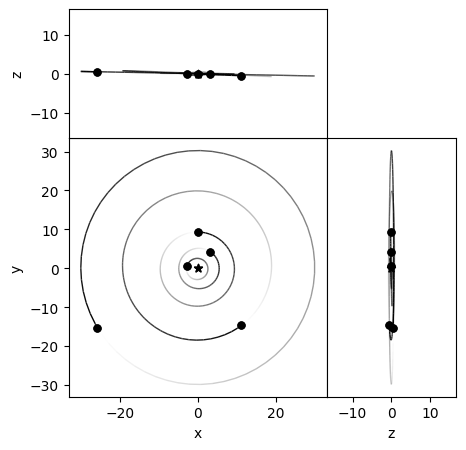

In [176]:
%%time

sim.integrator='whfast'
sim.dt = ps[1].P/100.
sim.ri_whfast.safe_mode = 0

Tfin_approx = 1.5e6*ps[-1].P
total_steps = np.ceil(Tfin_approx / sim.dt)
Tfin = total_steps * sim.dt + sim.dt
Nout = 262144

sim.save_to_file("asteroid_integration.sa", step=int(np.floor(total_steps/Nout)), delete_file=True)
sim.integrate(Tfin, exact_finish_time=0)
results = cm.nbody_simulation_utilities.get_simarchive_integration_results("asteroid_integration.sa",coordinates='heliocentric')

rb.OrbitPlotSet(sim)

In [134]:
results = cm.nbody_simulation_utilities.get_simarchive_integration_results("asteroid_integration.sa",coordinates='heliocentric')

(2.4540662874659964, 2.767028)

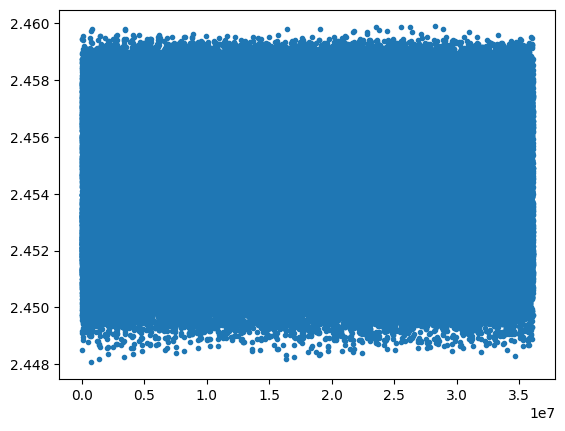

In [135]:
fig, ax = plt.subplots()
ax.plot(results['time'], results['a'][-1], '.')

results['a'][-1].mean(), merged_df.iloc[0]['propa']

## Calculate frequencies of planets and asteroid

In [136]:
def closest_key_entry(d, target):
	"""
	Given a dictionary `d` with float keys and a target float `target`,
	returns a tuple (key, value) where the key is the one in `d`
	closest to `target`.

	Parameters
	----------
	d : dict
		Dictionary with float keys.
	target : float
		The float to compare keys against.

	Returns
	-------
	tuple
		The (key, value) pair whose key is closest to `target`.
	"""
	closest_key = min(d.keys(), key=lambda k: abs(k - target))
	return closest_key, d[closest_key]

In [177]:
results['X'] = np.sqrt(2*(1-np.sqrt(1-results['e']**2))) * np.exp(1j * results['pomega'])
results['Y'] = (1-results['e']**2)**(0.25) * np.sin(0.5 * results['inc'] )* np.exp(1j * results['Omega'])

In [178]:
planets = ("Jupiter","Saturn","Uranus","Neptune", "Asteroid")
ecc_fmft_results = dict()
inc_fmft_results = dict()
for i,pl in enumerate(planets):
	ecc_fmft_results[pl] = fmft(results['time'],results['X'][i],14)
	planet_e_freqs = np.array(list(ecc_fmft_results[pl].keys()))
	planet_e_freqs_arcsec_per_yr = planet_e_freqs * 60*60*180/np.pi * (2*np.pi)

	inc_fmft_results[pl] = fmft(results['time'],results['Y'][i],8)
	planet_inc_freqs = np.array(list(inc_fmft_results[pl].keys()))
	planet_inc_freqs_arcsec_per_yr = planet_inc_freqs * 60*60*180/np.pi * (2*np.pi)

	print("")
	print(pl)
	print("g")
	print("-------")
	for g in planet_e_freqs[:6]:
		print("{:+07.3f} \t {:0.6f}".format(g * 60 * 60 * 180 / np.pi * (2 * np.pi), np.abs(ecc_fmft_results[pl][g])))
	print("s")
	print("-------")
	for g in planet_inc_freqs[:4]:
		print("{:+07.3f} \t {:0.6f}".format(g * 60 * 60 * 180 / np.pi * (2 * np.pi), np.abs(inc_fmft_results[pl][g])))


Jupiter
g
-------
+04.245 	 0.044206
+28.244 	 0.015694
+03.089 	 0.001842
-21265.243 	 0.000645
+52.243 	 0.000571
-5901.244 	 0.000396
s
-------
+00.000 	 0.013772
-26.338 	 0.003150
-00.692 	 0.000577
-02.993 	 0.000483

Saturn
g
-------
+28.244 	 0.048225
+04.245 	 0.032963
+52.243 	 0.001927
+1407.052 	 0.001546
+03.089 	 0.001532
-5901.244 	 0.001247
s
-------
+00.000 	 0.013767
-26.338 	 0.007852
-00.692 	 0.000555
-02.993 	 0.000393

Uranus
g
-------
+04.245 	 0.038097
+03.089 	 0.028995
+305.328 	 0.002078
+00.673 	 0.001681
+28.244 	 0.001549
+15424.235 	 0.001350
s
-------
+00.000 	 0.013771
-02.993 	 0.008882
-00.692 	 0.000555
-26.338 	 0.000354

Neptune
g
-------
+00.673 	 0.009160
+03.089 	 0.003704
+04.245 	 0.001943
+7864.782 	 0.001352
+305.328 	 0.000567
+6266.808 	 0.000164
s
-------
+00.000 	 0.013732
-00.692 	 0.005794
-02.993 	 0.001064
-02.337 	 0.000056

Asteroid
g
-------
+54.062 	 0.116482
+04.245 	 0.030951
+28.244 	 0.019816
+52.243 	 0.008839
-172.469 	 0

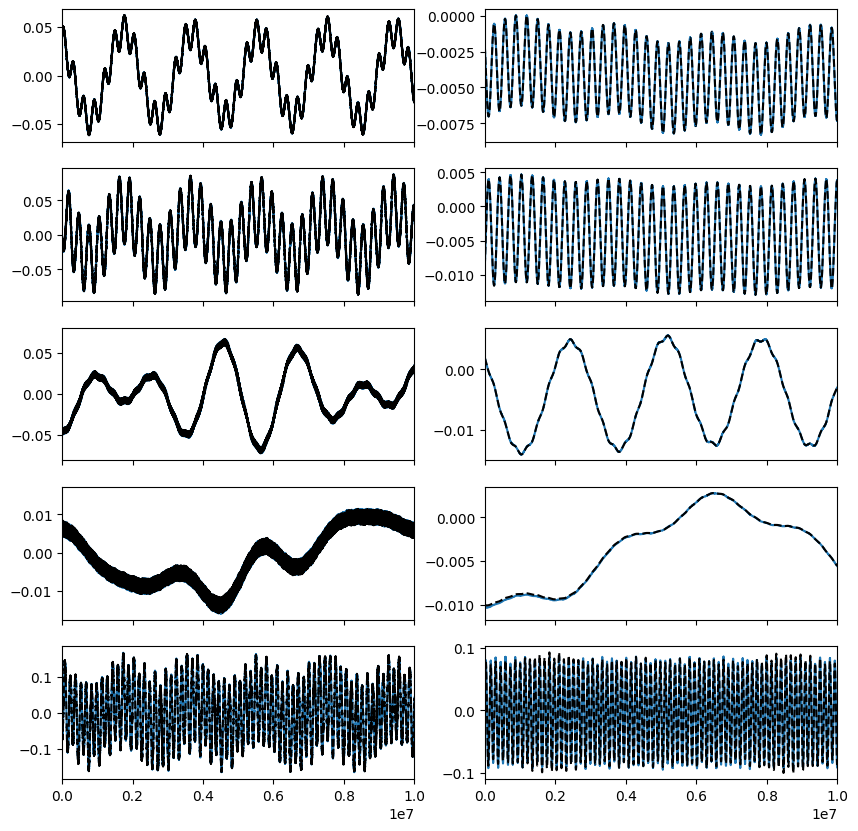

In [179]:
fig,ax = plt.subplots(sim.N-1,2,sharex=True,figsize=(10,10))
Xsolns = []
Ysolns = []
for i,pl in enumerate(planets):
	freq_amp_dict = ecc_fmft_results[pl]
	ax[i,0].plot(results['time'],np.real(results['X'][i]))
	zsoln = np.sum([amp * np.exp(1j*freq*results['time']) for freq,amp in freq_amp_dict.items()],axis=0)
	ax[i,0].plot(results['time'],np.real(zsoln),'k--')

	freq_amp_dict = inc_fmft_results[pl]
	Ysolns.append(freq_amp_dict)
	ax[i,1].plot(results['time'],np.real(results['Y'][i]))
	zsoln = np.sum([amp * np.exp(1j*freq*results['time']) for freq,amp in freq_amp_dict.items()],axis=0)
	ax[i,1].plot(results['time'],np.real(zsoln),'k--')
plt.xlim(0,1e7)
plt.show()

In [180]:
ARCSEC_PER_YR = 1/(180*60*60*2)
g_vec = np.zeros(4)
s_vec = np.zeros(3)

g_vec[:3] = np.array(list(ecc_fmft_results['Jupiter'].keys()))[:3]
g_vec[3] = list(ecc_fmft_results['Neptune'].keys())[0]
s_vec[0] = list(inc_fmft_results['Jupiter'].keys())[0]
s_vec[1] = list(inc_fmft_results['Jupiter'].keys())[2]
s_vec[2] = list(inc_fmft_results['Jupiter'].keys())[1]
omega_vec = np.concatenate((g_vec,s_vec))
g_and_s_arc_sec_per_yr = omega_vec / ARCSEC_PER_YR
g_and_s_arc_sec_per_yr

array([ 4.24505646e+00,  2.82441369e+01,  3.08920954e+00,  6.73152779e-01,
        1.07033669e-06, -6.91883979e-01, -2.63376671e+01])

## Asteroid Eccentricity Prediction

In [181]:
def k_vec_generation(max_order = 3, size = 7):
	kvecs = []
	
	for order in range(1, max_order + 1):
		for positions in combinations_with_replacement(range(size), order):
			for variables in combinations_with_replacement([-1, 1], order):
				k = np.zeros(size, dtype = int)
				for i, n in zip(positions, variables):
					k[i] += n
				kvecs.append(k)
	kvecs = np.array(kvecs)
	indices = np.where((kvecs == np.zeros(size)).all(axis = 1))
	kvecs = np.delete(kvecs, indices, axis=0)
	return kvecs

eye_N = k_vec_generation(max_order = 3, size = omega_vec.size)
eye_N

array([[-1,  0,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0],
       [ 0, -1,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0, -1],
       [ 0,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ...,  0,  0,  3]], shape=(427, 7))

In [182]:
def k_vec_generation(max_order = 3, size = 7):
	kvecs = [np.eye(size, dtype=int)[i] for i in range(size)]
	
	for order in range(2, max_order + 1):
		for positions in combinations_with_replacement(range(size), order):
			for variables in combinations_with_replacement([-1, 1], order):
				k = np.zeros(size, dtype = int)
				for i, n in zip(positions, variables):
					k[i] += n
				kvecs.append(k)
	kvecs = np.array(kvecs)
	indices = np.where((kvecs == np.zeros(size)).all(axis = 1))
	kvecs = np.delete(kvecs, indices, axis=0)
	return kvecs
eye_N = k_vec_generation(max_order = 3, size = omega_vec.size)

x_dicts = []
for pl in planets:
	print(pl)    
	print("-"*len(pl))
	print("kvec \t\t\t omega \t err. \t amplitude")
	x_dict = {}
	for i,omega_i in enumerate(omega_vec[:4]):
		omega_N,amp = closest_key_entry(ecc_fmft_results[pl],omega_vec[i])
		omega_error = np.abs(omega_N/omega_i-1)
		if omega_error<0.001:
			print (eye_N[i],"\t{:+07.3f}\t{:.1g} \t{:.1g}".format(omega_i/ARCSEC_PER_YR,omega_error,np.abs(amp)))
			x_dict[tuple(eye_N[i])] = amp
	#NL terms
	for a in range(7):
		for b in range(a,7):
			for c in range(7):
				if c==a:
					continue
				if c==b:
					continue
				k = np.zeros(7,dtype = int)
				k[a] +=1
				k[b] +=1
				k[c] -=1
				omega=k@omega_vec
				omega_N,amp = closest_key_entry(ecc_fmft_results[pl],omega)
				omega_error = np.abs(omega_N/omega-1)
				if omega_error<0.001:
					print (k,"\t{:+07.3f}\t{:.1g},\t{:.1g}".format(omega/ARCSEC_PER_YR,omega_error,np.abs(amp)))
					x_dict[tuple(k)] = amp
	x_dicts.append(x_dict)

Jupiter
-------
kvec 			 omega 	 err. 	 amplitude
[1 0 0 0 0 0 0] 	+04.245	0 	0.04
[0 1 0 0 0 0 0] 	+28.244	0 	0.02
[0 0 1 0 0 0 0] 	+03.089	0 	0.002
[ 1  1 -1  0  0  0  0] 	+29.400	5e-06,	0.0002
[-1  2  0  0  0  0  0] 	+52.243	3e-07,	0.0006
[-1  1  1  0  0  0  0] 	+27.088	9e-06,	0.0002
[ 0  1  0  1 -1  0  0] 	+28.917	0.0009,	0.0001
[ 0  0  1  0  1  0 -1] 	+29.427	0.0009,	0.0002
Saturn
------
kvec 			 omega 	 err. 	 amplitude
[1 0 0 0 0 0 0] 	+04.245	5e-09 	0.03
[0 1 0 0 0 0 0] 	+28.244	1e-10 	0.05
[0 0 1 0 0 0 0] 	+03.089	2e-06 	0.002
[ 1  1 -1  0  0  0  0] 	+29.400	5e-06,	0.0006
[-1  2  0  0  0  0  0] 	+52.243	3e-07,	0.002
[-1  1  1  0  0  0  0] 	+27.088	9e-06,	0.0006
[ 0  1  0  1 -1  0  0] 	+28.917	0.0009,	0.0004
[ 0  0  1  0  1  0 -1] 	+29.427	0.0009,	0.0006
Uranus
------
kvec 			 omega 	 err. 	 amplitude
[1 0 0 0 0 0 0] 	+04.245	4e-07 	0.04
[0 1 0 0 0 0 0] 	+28.244	9e-08 	0.002
[0 0 1 0 0 0 0] 	+03.089	4e-06 	0.03
[0 0 0 1 0 0 0] 	+00.673	0.0002 	0.002
[ 2  0 -1  0  0  0  0] 	+05.

In [183]:
def k_vec_generation(max_order = 3, size = 7):
	kvecs = []
	units = list(range(size))
	
	for order in range(1, max_order + 1):
		for indices in combinations_with_replacement(range(size), order):
			for signs in combinations_with_replacement([-1, 1], order):
				k = np.zeros(size, dtype = int)
				for i, n in zip(indices, signs):
					k[i] += n
				kvecs.append(k)
	kvecs = np.array(kvecs)
	kvecs = kvecs[~np.all(kvecs == 0, axis = 1)]
	return kvecs

eye_N = k_vec_generation(max_order = 3, size = omega_vec.size)
y_dicts = []
for pl in planets:
	print(pl)    
	print("-"*len(pl))
	print("kvec \t\t\t omega \t err. \t amplitude")
	y_dict = {}
	for i,omega_i in enumerate(omega_vec[4:]):
		omega_N,amp = closest_key_entry(inc_fmft_results[pl],omega_vec[i])
		omega_error = np.abs(omega_N/omega_i-1)
		if omega_error<0.001:
			print (eye_N[i],"\t{:+07.3f}\t{:.1g} \t{:.1g}".format(omega_i/ARCSEC_PER_YR,omega_error,np.abs(amp)))
			y_dict[tuple(eye_N[i])] = amp
	#NL terms
	for a in range(7):
		for b in range(a,7):
			for c in range(7):
				if c==a:
					continue
				if c==b:
					continue
				k = np.zeros(7,dtype = int)
				k[a] +=1
				k[b] +=1
				k[c] -=1
				omega=k@omega_vec
				omega_N,amp = closest_key_entry(inc_fmft_results[pl],omega)
				omega_error = np.abs(omega_N/omega-1)
				if omega_error<0.001:
					print (k,"\t{:+07.3f}\t{:.1g},\t{:.1g}".format(omega/ARCSEC_PER_YR,omega_error,np.abs(amp)))
					y_dict[tuple(k)] = amp
	y_dicts.append(y_dict)

Jupiter
-------
kvec 			 omega 	 err. 	 amplitude
[-1  0  0  0  0  0  0] 	+00.000	0 	0.01
[ 0  2  0  0  0  0 -1] 	+82.826	5e-08,	1e-05
[-1  1  0  0  0  0  1] 	-02.339	0.0006,	2e-05
[ 0  0  0 -1  1  0  1] 	-27.011	0.0007,	2e-05
Saturn
------
kvec 			 omega 	 err. 	 amplitude
[ 1  1  0  0  0  0 -1] 	+58.827	3e-08,	2e-05
[ 0  2  0  0  0  0 -1] 	+82.826	5e-08,	4e-05
[ 0  0  0 -1  1  0  1] 	-27.011	0.0007,	6e-05
Uranus
------
kvec 			 omega 	 err. 	 amplitude
[-1  1  0  0  0  0  1] 	-02.339	8e-05,	0.0003
Neptune
-------
kvec 			 omega 	 err. 	 amplitude
[-1  1  0  0  0  0  1] 	-02.339	0.0007,	6e-05
Asteroid
--------
kvec 			 omega 	 err. 	 amplitude


In [143]:
eye_N

array([[-1,  0,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0],
       [ 0, -1,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0, -1],
       [ 0,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ...,  0,  0,  3]], shape=(427, 7))

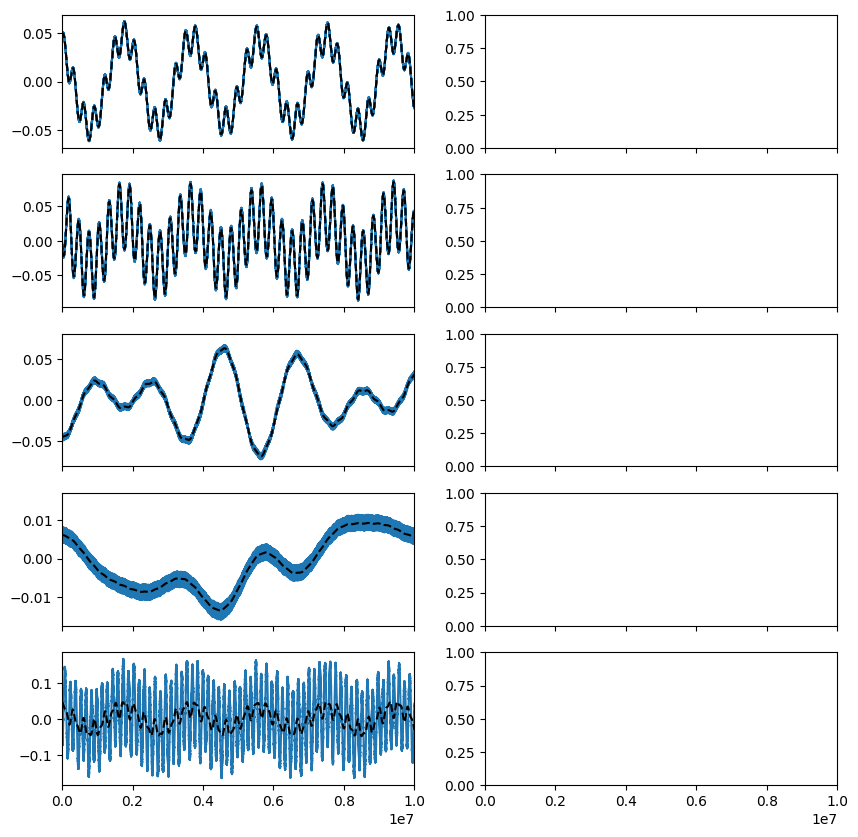

In [184]:
fig,ax = plt.subplots(sim.N-1,2,sharex=True,figsize=(10,10))
Xsolns = []
Ysolns = []
for i,pl in enumerate(planets):
	freq_amp_dict = ecc_fmft_results[pl]
	ax[i,0].plot(results['time'],np.real(results['X'][i]))
	zsoln = np.sum([np.abs(amp) * np.exp(1j*((np.array(k)@omega_vec)*results['time'] + + np.angle(amp))) for k,amp in x_dicts[i].items()],axis=0)
	ax[i,0].plot(results['time'],np.real(zsoln),'k--')
plt.xlim(0,1e7)
plt.show()

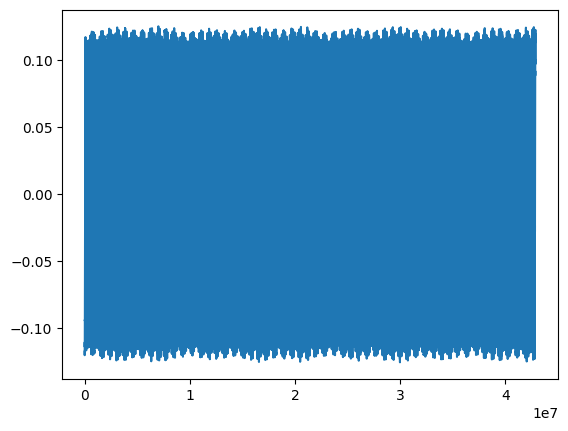

In [185]:
freq_amp_dict = ecc_fmft_results['Asteroid']
zsoln = np.sum([np.abs(amp) * np.exp(1j*((np.array(k)@omega_vec)*results['time'] + + np.angle(amp))) for k,amp in x_dicts[-1].items()],axis=0)
soln_wo_planets = results['X'][i] - zsoln
plt.plot(results['time'], np.real(soln_wo_planets))

In [186]:
ecc_fmft_result = fmft(results['time'], soln_wo_planets, 14)

asteroid_e_freqs = np.array(list(ecc_fmft_result.keys()))
asteroid_e_freqs_arcsec_per_yr = asteroid_e_freqs * 60*60*180/np.pi * (2*np.pi)
print(asteroid_e_freqs)

print("")
print(pl)
print("g")
print("-------")
print(ecc_fmft_results)
for g in asteroid_e_freqs[:6]:
	print("{:+07.3f} \t {:0.6f}".format(g * 60 * 60 * 180 / np.pi * (2 * np.pi), np.abs(ecc_fmft_results[g])))

[ 4.17141502e-05 -1.33078349e-04 -9.99605384e-03 -1.34481373e-04
  7.30150892e-03  4.31188887e-05 -1.31674068e-04  4.08211428e-05
  4.22315219e-05 -1.32564333e-04 -1.33588901e-04  6.70739431e-05
  1.63544170e-05  4.26053925e-05]

Asteroid
g
-------
{'Jupiter': {np.float64(3.275506525568753e-06): np.complex128(0.0380586777905241+0.022487061783631735j), np.float64(2.1793315533965187e-05): np.complex128(0.009708559989956659-0.012330238209862837j), np.float64(2.3836493336042403e-06): np.complex128(-0.0009164096227866123+0.00159800408669908j), np.float64(-0.016408366893449808): np.complex128(-0.00048406991490530934+0.00042635508389628283j), np.float64(4.031113653394077e-05): np.complex128(0.000397907925518453+0.0004097196520087936j), np.float64(-0.004553428985843359): np.complex128(-0.00019005910876044427+0.0003475319681648983j), np.float64(0.0010856878941866441): np.complex128(-0.00028728041055939735+0.0002504614624697421j), np.float64(2.090164598128639e-05): np.complex128(-0.0001599792084

KeyError: np.float64(4.171415016493937e-05)

In [ ]:
ecc_fmft_results

{'Jupiter': {np.float64(3.275506525568753e-06): np.complex128(0.0380586777905241+0.022487061783631735j),
  np.float64(2.1793315533965187e-05): np.complex128(0.009708559989956659-0.012330238209862837j),
  np.float64(2.3836493336042403e-06): np.complex128(-0.0009164096227866123+0.00159800408669908j),
  np.float64(-0.016408366893449808): np.complex128(-0.00048406991490530934+0.00042635508389628283j),
  np.float64(4.031113653394077e-05): np.complex128(0.000397907925518453+0.0004097196520087936j),
  np.float64(-0.004553428985843359): np.complex128(-0.00019005910876044427+0.0003475319681648983j),
  np.float64(0.0010856878941866441): np.complex128(-0.00028728041055939735+0.0002504614624697421j),
  np.float64(2.090164598128639e-05): np.complex128(-0.00015997920845715283-0.00012187334788873387j),
  np.float64(2.2685288287390044e-05): np.complex128(-0.0001537845245970527-0.0001239841515996173j),
  np.float64(0.017515848096178562): np.complex128(-8.123156731077034e-05+0.0001020899804787459j),
  n